# Libraries

In [1]:
# Import necessary libraries
import pandas as pd
import datetime as dt
import numpy as np
import math
import re
import seaborn as sns
from scipy.stats import norm
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from mlxtend.frequent_patterns import association_rules, fpgrowth
from sklearn.metrics.pairwise import linear_kernel, cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
import warnings
warnings.filterwarnings('ignore')

# Settings

In [2]:
# Data location
# folder = 'C:/Users/Sam/Desktop/NW Work/DATA/421/hw03/' # Laptop
folder = 'C:/Users/nuke2/Desktop/NW Work/Data/421/hw03/' # Desktop

# Data

In [3]:
# read the csv files into dataframes
df_products = pd.read_csv(folder+'Products.csv')
df_customers_og = pd.read_csv(folder+'customers.csv')
df_orders = pd.read_csv(folder+'orders.csv')

# merge the dataframes
df_all = pd.merge(df_orders, df_customers_og, on='CustomerId')
df_all = pd.merge(df_all, df_products, on='ProductId')

# convert the 'Date' column to datetime format
df_all['Date'] = pd.to_datetime(df_all['Date'])

# Get total_spend
df_all['total_spend'] = df_all['Quantity'] * df_all['Price']

# display the first few rows of the merged dataframe
df_all.head()

,Date,CustomerId,ProductId,Quantity,Rating,name,address,ProductName,Price,total_spend
0,2021-01-01,C925,P117,5,3.0,Anna Wilson,"3018 Travis Village Suite 007,Hughesport, WY 9...",Wireless Headphones,150,750
1,2021-02-18,C399,P117,9,4.0,Ryan Schmidt,"917 Kayla Trail,West Andrea, NM 09296",Wireless Headphones,150,1350
2,2021-11-17,C369,P117,4,2.0,Kelly Wood,"367 Hunt Ranch,Port Christopher, MP 13875",Wireless Headphones,150,600
3,2021-02-17,C34,P117,1,5.0,David Yates,"5930 Hailey Neck,Garciaton, TX 81701",Wireless Headphones,150,150
4,2022-01-09,C34,P117,8,1.0,David Yates,"5930 Hailey Neck,Garciaton, TX 81701",Wireless Headphones,150,1200


# Clean Data

In [4]:
# describe the dataframe
print("Dataframe description:\n")
print(df_all.describe())
print("\n=========================\n")

# check for null values
print("Null values:\n")
print(df_all.isnull().sum())

# drop rows with null values
df_all.dropna(inplace=True)

# Check for irregular rows
def filter_strings(strings, col='C'):
    if col=='C':
        pattern = r'^C\d{1,4}$'
    elif col=='P':
        pattern = r'^P\d{1,3}$'
    
    regex = re.compile(pattern)
    filtered_strings = [s for s in strings if not regex.match(s)]
    return filtered_strings

print("\n=========================\n")
print('Incorrect column format:\n')
print(f"CustomerId: {len(filter_strings(df_all.CustomerId, col='C'))}")
print(f"ProductId: {len(filter_strings(df_all.ProductId, col='P'))}")

Dataframe description:

           Quantity        Rating         Price   total_spend
count  75000.000000  67870.000000  75000.000000  75000.000000
mean       5.008187      3.001459    100.939480    505.543027
std        2.584899      1.415853    189.108321   1093.371467
min        1.000000      1.000000      2.000000      2.000000
25%        3.000000      2.000000     15.000000     60.000000
50%        5.000000      3.000000     50.000000    160.000000
75%        7.000000      4.000000    100.000000    450.000000
max        9.000000      5.000000   1200.000000  10800.000000


Null values:

Date              0
CustomerId        0
ProductId         0
Quantity          0
Rating         7130
name              0
address           0
ProductName       0
Price             0
total_spend       0
dtype: int64


Incorrect column format:

CustomerId: 0
ProductId: 0


# EDA

In [5]:
print("Number of customers:", df_all.CustomerId.unique().shape[0])
print("Number of ProductIds:", df_all.ProductId.unique().shape[0])

Number of customers: 1499
Number of ProductIds: 118


In [6]:
def extract_state(address):
    # Define a regular expression pattern to match state abbreviations
    pattern = r'\b[A-Z]{2}\b'
    
    # Use re.findall to find all occurrences of the pattern in the address string
    matches = re.findall(pattern, address)
    
    # If matches were found, return the first one
    if matches:
        return matches[0]
    else:
        return None

# Get state column and check how many are null
df_all['state'] = df_all['address'].apply(extract_state)
print(f"Num null states: {sum(df_all['state'].isnull())} \n\n=========================\n")
print('Top 10 states (# transactions)\n')
print(df_all.groupby('state')['CustomerId'].count().sort_values(ascending=False)[:10])

Num null states: 0 


Top 10 states (# transactions)

state
AE    2458
AA    2315
AP    2214
SC    1521
GU    1464
MN    1435
VT    1429
VA    1396
KS    1346
MA    1313
Name: CustomerId, dtype: int64


# RFM

In [7]:
df_all.head()

,Date,CustomerId,ProductId,Quantity,Rating,name,address,ProductName,Price,total_spend,state
0,2021-01-01,C925,P117,5,3.0,Anna Wilson,"3018 Travis Village Suite 007,Hughesport, WY 9...",Wireless Headphones,150,750,WY
1,2021-02-18,C399,P117,9,4.0,Ryan Schmidt,"917 Kayla Trail,West Andrea, NM 09296",Wireless Headphones,150,1350,NM
2,2021-11-17,C369,P117,4,2.0,Kelly Wood,"367 Hunt Ranch,Port Christopher, MP 13875",Wireless Headphones,150,600,MP
3,2021-02-17,C34,P117,1,5.0,David Yates,"5930 Hailey Neck,Garciaton, TX 81701",Wireless Headphones,150,150,TX
4,2022-01-09,C34,P117,8,1.0,David Yates,"5930 Hailey Neck,Garciaton, TX 81701",Wireless Headphones,150,1200,TX


In [8]:
df_carts = df_all.groupby(by=['CustomerId', 'Date']).agg({
    'Price': 'count',
    'total_spend': 'sum'
}).sort_values(by='Price', ascending=False).copy().reset_index()

# Get extra date column for later
df_carts['Date_init'] = df_carts['Date']

df_carts.head()

,CustomerId,Date,Price,total_spend,Date_init
0,C235,2021-06-02,4,1310,2021-06-02
1,C325,2021-02-08,3,495,2021-02-08
2,C1444,2021-09-27,3,330,2021-09-27
3,C1459,2021-02-09,3,3060,2021-02-09
4,C309,2021-02-17,3,10050,2021-02-17


In [9]:
# get the last invoice date in the dataset
max_date = df_carts['Date'].max()
print("Max Date:", max_date)

# adding a day to the calculated max date as date of analysis
snapshot = max_date + dt.timedelta(days = 1)
print("Snapshot Date:", snapshot)

Max Date: 2022-01-31 00:00:00
Snapshot Date: 2022-02-01 00:00:00


In [10]:
# Group and aggregate the data to get RFM dataframe
df_customers = df_carts.groupby(by=['CustomerId']).agg({
    'Date': 'max',
    'Date_init': 'min',
    'Price': 'count',
    'total_spend': 'sum'
}).reset_index().rename(columns={'Price': 'Frequency', 'total_spend': 'Monetary'}).copy()

# Calculate Recency and Tenure
df_customers['Recency'] = (max_date - df_customers['Date']).dt.days
df_customers['Tenure'] = (max_date - df_customers['Date_init']).dt.days

# Reorder columns
df_customers = df_customers[['CustomerId', 'Recency', 'Frequency', 'Monetary', 'Tenure']]

# Print the first few rows of the resulting dataframe
df_customers.head()

,CustomerId,Recency,Frequency,Monetary,Tenure
0,C0,3,51,18916,391
1,C1,12,36,16520,392
2,C10,28,50,23490,373
3,C100,3,41,13897,385
4,C1000,12,55,24293,392


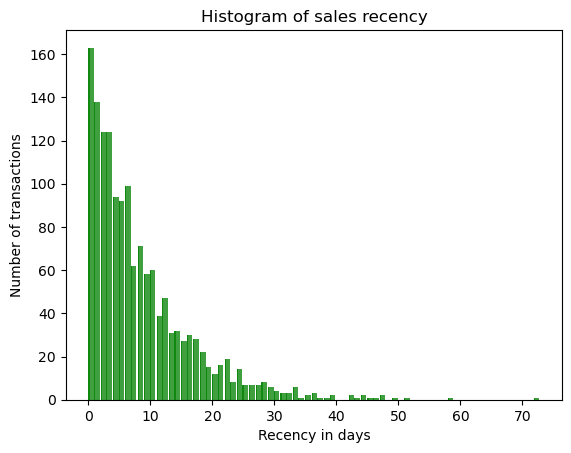

In [11]:
# plot recency
recency = df_customers.Recency
mu = np.mean(recency)  # calculate mean
sigma = math.sqrt(np.var(recency))  # calculate standard deviation
n, bins, patches = plt.hist(recency, 400, facecolor='green', alpha=0.75) # plot histogram
plt.bar(bins[:-1], n, width=0.9, align='edge', color='green', alpha=0.75)
plt.xlabel('Recency in days')
plt.ylabel('Number of transactions')
plt.title(r'Histogram of sales recency')
plt.grid(False)  # add gridlines

In [12]:
#scale all RFMT values in the range 1-5
min_max_scaler = MinMaxScaler((1,5))
scaled = min_max_scaler.fit_transform(df_customers[["Recency","Frequency","Monetary","Tenure"]])
df_customers = pd.DataFrame(scaled, columns=["Recency","Frequency","Monetary","Tenure"])
df_customers.head()

,Recency,Frequency,Monetary,Tenure
0,1.166667,3.476190,2.046959,4.768116
1,1.666667,2.047619,1.852214,4.826087
2,2.555556,3.380952,2.418731,3.724638
3,1.166667,2.523810,1.639018,4.420290
4,1.666667,3.857143,2.483998,4.826087


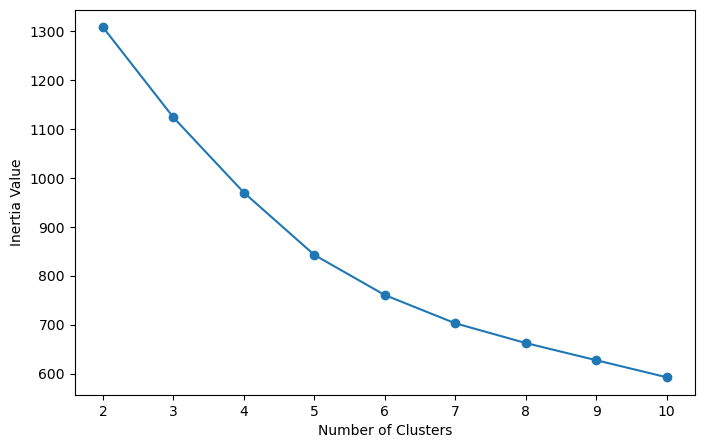

In [13]:
X = df_customers.values 
n_cluster_range = range(2, 11)
cost = []

# loop over number of clusters and compute the cost function for each number
for n_clusters in n_cluster_range:
    # create a KMeans object with n_clusters clusters and fit to data
    kmeans = KMeans(n_clusters=n_clusters, random_state=13)
    kmeans.fit(X)
    # append the cost (inertia) to the list of costs
    cost.append(kmeans.inertia_)

# plot the cost vs. number of clusters
fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(n_cluster_range, cost, marker="o")
ax.set_xlabel("Number of Clusters")
ax.set_ylabel("Inertia Value")
plt.show()

In [14]:
n_cluster = 6 # k=6 seems to be where the majority of the inertia decreases by

# Define the KMeans model
model = KMeans(n_clusters=n_cluster, random_state=2023)

# Fit the model and predict the segments for each customer
y = model.fit_predict(df_customers[["Recency", "Frequency", "Monetary", "Tenure"]])

# Add the new segment column to the original dataframe
df_customers["Segment"] = y

# Display the first few rows of the updated dataframe
df_customers.head()

,Recency,Frequency,Monetary,Tenure,Segment
0,1.166667,3.476190,2.046959,4.768116,5
1,1.666667,2.047619,1.852214,4.826087,2
2,2.555556,3.380952,2.418731,3.724638,0
3,1.166667,2.523810,1.639018,4.420290,2
4,1.666667,3.857143,2.483998,4.826087,5


In [15]:
# Create a dataframe grouped by segment and calculate the mean values
df_eval_tiers = df_customers.groupby("Segment").mean().copy()

# Calculate the score for each segment based on recency, frequency, and monetary value
df_eval_tiers["Score"] = 0.6*(5-df_eval_tiers['Recency']) + 0.2*df_eval_tiers['Frequency'] + 0.2*df_eval_tiers['Monetary']

# Sort the dataframe by score in descending order
df_eval_tiers = df_eval_tiers.sort_values('Score', ascending=False).reset_index()

df_eval_tiers

,Segment,Recency,Frequency,Monetary,Tenure,Score
0,1,1.356080,3.320210,3.361689,4.638480,3.522731
1,5,1.313744,3.178915,2.143351,4.680322,3.276207
2,3,1.336970,2.434459,2.687967,4.669671,3.222303
3,4,1.423715,2.463397,2.254224,3.478045,3.089295
4,2,1.334129,2.190886,1.723909,4.604003,2.982481
5,0,2.492120,2.413036,2.205416,4.628328,2.428419


In [16]:
# Create a dictionary to map each segment to its corresponding tier label
humanization = {}
tiers = ["Diamond", "Platinum", "Gold", "Silver", "Bronze", "Iron"]

# Iterate over the segments and assign the corresponding tier label based on the score ranking
score_check = df_eval_tiers.Score
for idx, row in df_eval_tiers.iterrows():
    humanization[row.Segment] = tiers[idx]
    
# Replace the numerical segment labels with the corresponding tier labels
df_customers["Segment"].replace(humanization, inplace=True)

# Display the updated dataframe
df_customers.head()

,Recency,Frequency,Monetary,Tenure,Segment
0,1.166667,3.476190,2.046959,4.768116,Platinum
1,1.666667,2.047619,1.852214,4.826087,Bronze
2,2.555556,3.380952,2.418731,3.724638,Iron
3,1.166667,2.523810,1.639018,4.420290,Bronze
4,1.666667,3.857143,2.483998,4.826087,Platinum


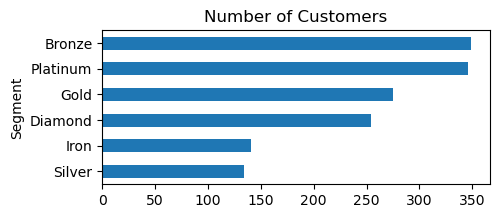

In [17]:
# Group by segment and plot rows in descending order
df_customers.groupby('Segment').size().sort_values(ascending=True).plot(
    title="Number of Customers",
    kind='barh',
    figsize=(5, 2),
)

# Show plot
plt.show()

# Market Basket

In [18]:
market_basket_df = df_all.copy()
market_basket_df.head()

,Date,CustomerId,ProductId,Quantity,Rating,name,address,ProductName,Price,total_spend,state
0,2021-01-01,C925,P117,5,3.0,Anna Wilson,"3018 Travis Village Suite 007,Hughesport, WY 9...",Wireless Headphones,150,750,WY
1,2021-02-18,C399,P117,9,4.0,Ryan Schmidt,"917 Kayla Trail,West Andrea, NM 09296",Wireless Headphones,150,1350,NM
2,2021-11-17,C369,P117,4,2.0,Kelly Wood,"367 Hunt Ranch,Port Christopher, MP 13875",Wireless Headphones,150,600,MP
3,2021-02-17,C34,P117,1,5.0,David Yates,"5930 Hailey Neck,Garciaton, TX 81701",Wireless Headphones,150,150,TX
4,2022-01-09,C34,P117,8,1.0,David Yates,"5930 Hailey Neck,Garciaton, TX 81701",Wireless Headphones,150,1200,TX


In [19]:
# Create invoice_id column by combining Date and CustomerId
market_basket_df['invoice_id'] = market_basket_df.Date.astype('str').str.replace('-', '') + market_basket_df['CustomerId'].str.replace('C', '0')

# Group by invoice_id and ProductName, sum Quantity, then unstack and fill missing values with 0
basket = market_basket_df.groupby(['invoice_id', 'ProductName'])['Quantity'].sum().unstack().reset_index().fillna(0).set_index('invoice_id')

# Print shape and head of basket
print("Shape of basket:", basket.shape)
basket.head()

Shape of basket: (64236, 117)


ProductName,Backpack,Badminton Racket,Baseball Bat,Baseball Glove,Basketball,Basketball Shoes,Bathrobe,Beach Towel,Blanket,Bluetooth Speaker,...,Video Game Console,Volleyball,Volleyball Net,Wallet,Water Bottle,Weightlifting Belt,Weightlifting Shoes,Wireless Headphones,Women's Watch,Yoga Mat
invoice_id,,,,,,,,,,,,,,,,,,,,,
2021010101001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2021010101003,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2021010101004,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2021010101008,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2021010101010,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [20]:
# get binary if purchased 1 else 0 for each invoice
def encode_units(x):
    if x >= 1:
        return 1
    else:
        return 0

#convert each value into 0 or 1
basket_sets = basket.applymap(encode_units)
basket_sets.head()

ProductName,Backpack,Badminton Racket,Baseball Bat,Baseball Glove,Basketball,Basketball Shoes,Bathrobe,Beach Towel,Blanket,Bluetooth Speaker,...,Video Game Console,Volleyball,Volleyball Net,Wallet,Water Bottle,Weightlifting Belt,Weightlifting Shoes,Wireless Headphones,Women's Watch,Yoga Mat
invoice_id,,,,,,,,,,,,,,,,,,,,,
2021010101001,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
2021010101003,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2021010101004,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2021010101008,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2021010101010,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [21]:
# Get num items per basket
df_item_count = basket_sets.sum(numeric_only = True, axis=1).reset_index(name ='ItemCount')
df_item_count.head()

,invoice_id,ItemCount
0,2021010101001,1
1,2021010101003,1
2,2021010101004,1
3,2021010101008,2
4,2021010101010,1


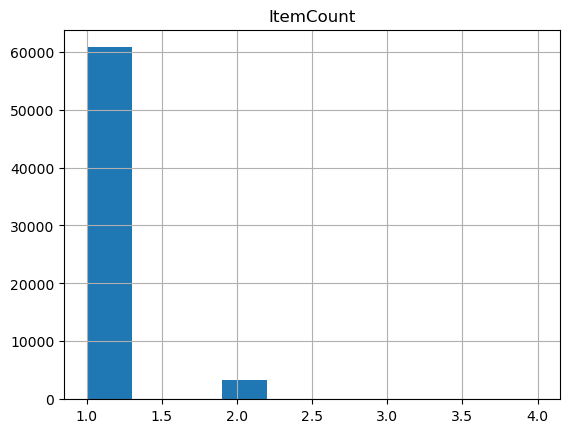

In [22]:
# Plot hist of item counts per basket
df_item_count.hist()
plt.show()

In [23]:
#set thresholds for support, lift and confidence
min_support = 0.00001
min_lift = 0
min_confidence = 0.01

Apriori broken for this dataset, kernel keeps breaking

In [24]:
frequent_itemsets = fpgrowth(basket_sets, min_support = min_support, use_colnames = True).sort_values('support', ascending=False)
frequent_itemsets['length'] = frequent_itemsets['itemsets'].apply(lambda x: len(x))
frequent_itemsets.head()

,support,itemsets,length
39,0.016688,(Umbrella),1
30,0.009854,(Rain Boots),1
7,0.009823,(Jeans),1
103,0.009714,(Tote Bag),1
15,0.009683,(Bluetooth Speaker),1


In [25]:
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=0)
filtered_rules = rules[(rules['lift'] >= min_lift) & (rules['confidence'] >= min_confidence)]
filtered_rules = filtered_rules.sort_values(by=['lift', 'confidence'], ascending=False)

filtered_rules.head()

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
5920,"(Passport Holder, Sneakers)","(Fitness Tracker, Weightlifting Belt)",0.000016,0.000016,0.000016,1.0,64236.0,0.000016,inf
5921,"(Fitness Tracker, Weightlifting Belt)","(Passport Holder, Sneakers)",0.000016,0.000016,0.000016,1.0,64236.0,0.000016,inf
5922,"(Fitness Tracker, Sneakers)","(Passport Holder, Weightlifting Belt)",0.000016,0.000031,0.000016,1.0,32118.0,0.000016,inf
5919,"(Passport Holder, Weightlifting Belt)","(Fitness Tracker, Sneakers)",0.000031,0.000016,0.000016,0.5,32118.0,0.000016,1.999969
5923,"(Weightlifting Belt, Sneakers)","(Passport Holder, Fitness Tracker)",0.000016,0.000047,0.000016,1.0,21412.0,0.000016,inf


# Recommendation Engines

In [26]:
df_reccomendation = df_all.copy()
df_reccomendation.head()

,Date,CustomerId,ProductId,Quantity,Rating,name,address,ProductName,Price,total_spend,state
0,2021-01-01,C925,P117,5,3.0,Anna Wilson,"3018 Travis Village Suite 007,Hughesport, WY 9...",Wireless Headphones,150,750,WY
1,2021-02-18,C399,P117,9,4.0,Ryan Schmidt,"917 Kayla Trail,West Andrea, NM 09296",Wireless Headphones,150,1350,NM
2,2021-11-17,C369,P117,4,2.0,Kelly Wood,"367 Hunt Ranch,Port Christopher, MP 13875",Wireless Headphones,150,600,MP
3,2021-02-17,C34,P117,1,5.0,David Yates,"5930 Hailey Neck,Garciaton, TX 81701",Wireless Headphones,150,150,TX
4,2022-01-09,C34,P117,8,1.0,David Yates,"5930 Hailey Neck,Garciaton, TX 81701",Wireless Headphones,150,1200,TX


### Popularity Based Engine

In [27]:
# Get ratings for each item
avg_rating = df_reccomendation.groupby(['ProductId']).agg({
    'Rating': 'mean',
    'CustomerId': 'count',
    'ProductName': 'max'
}).reset_index().rename(columns={'Rating': 'avg_rating', 'CustomerId': 'no_ratings'}).copy()

In [28]:
# We have the items sorted from highest number of purchases to lowest
avg_rating = avg_rating.sort_values(['no_ratings'], ascending=False)
avg_rating.head()

,ProductId,avg_rating,no_ratings,ProductName
89,P73,3.056872,633,Rain Boots
74,P6,3.031696,631,Jeans
49,P37,2.971154,624,Tote Bag
21,P118,2.995177,622,Bluetooth Speaker
19,P116,3.022544,621,Video Game


### Content Based Engine

In [29]:
# removing the stop words
tfidf = TfidfVectorizer(stop_words='english')

# computing TF-IDF matrix required for calculating cosine similarity
products_tfidf = tfidf.fit_transform(df_products['ProductName'])

# shape of computed matrix
print(f"Products_tfidf shape: {products_tfidf.shape}")

# computing cosine similarity matrix using linear_kernal of sklearn
cosine_similarity = linear_kernel(products_tfidf, products_tfidf)

Products_tfidf shape: (119, 146)


In [30]:
def get_similarities(product):
    
    """
    Returns the name of a product and the names of the top 5 most similar products based on cosine similarity scores.

    Parameters:
    product (int): The index of the product to get similarities for.

    Returns:
    tuple: A tuple containing the name of the product and a Pandas Series with the names of the top 5 most similar products.
    If there are no similar products, the tuple will contain the name of the product and the string 'Nothing'.
    """
    
    # Get product
    product_name = df_products['ProductName'].iloc[product]
    
    # Get list of similarity values
    similarity_list = list(enumerate(cosine_similarity[product]))
    
    # get the top 5 similar books
    similarity_list = sorted(similarity_list, key=lambda x: x[1], reverse=True)
    similarity_list = similarity_list[1:6]
    
    # Get the similar books index
    product_index = [i[0] for i in similarity_list if i[1] > 0]
    
    # print the top 5 most similar books
    top_products = df_products['ProductName'].iloc[product_index]
    
    # Check for no similar items
    if len(top_products) == 0:
        top_products = 'Nothing'
    
    return (product_name, top_products)

item_similarities = get_similarities(4)
print(f"{item_similarities[0]} is similar to: \n{item_similarities[1]}")

Dress Shirt is similar to: 
3           T-shirt
26      Dress Shoes
75    Running Shirt
Name: ProductName, dtype: object


### Collaborative Filter

In [31]:
# Build the user-item matrix
user_item = pd.pivot_table(data=df_reccomendation, values='Rating', index='CustomerId', columns='ProductId')
user_item.replace('',np.nan,inplace=True) 
user_item.head()

ProductId,P1,P10,P100,P101,P102,P103,P104,P105,P106,P107,...,P90,P91,P92,P93,P94,P95,P96,P97,P98,P99
CustomerId,,,,,,,,,,,,,,,,,,,,,
C0,NaN,NaN,1.0,3.5,NaN,NaN,1.5,NaN,NaN,3.0,...,4.0,NaN,NaN,2.0,5.0,NaN,5.0,NaN,NaN,NaN
C1,NaN,NaN,2.5,NaN,NaN,NaN,NaN,2.0,NaN,3.0,...,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,4.0,5.0
C10,NaN,5.0,5.0,1.0,4.0,3.0,1.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,3.0
C100,NaN,NaN,4.5,NaN,NaN,NaN,NaN,5.0,3.0,NaN,...,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN
C1000,5.0,NaN,NaN,NaN,NaN,5.0,NaN,2.0,NaN,NaN,...,2.0,NaN,5.0,NaN,1.0,NaN,2.0,NaN,NaN,NaN


In [32]:
# Normalize user-item matrix
user_item_norm = user_item.subtract(user_item.mean(axis=1), axis = 0)
user_item_norm.head()

ProductId,P1,P10,P100,P101,P102,P103,P104,P105,P106,P107,...,P90,P91,P92,P93,P94,P95,P96,P97,P98,P99
CustomerId,,,,,,,,,,,,,,,,,,,,,
C0,NaN,NaN,-2.019380,0.480620,NaN,NaN,-1.519380,NaN,NaN,-0.01938,...,0.980620,NaN,NaN,-1.01938,1.980620,NaN,1.980620,NaN,NaN,NaN
C1,NaN,NaN,-0.196970,NaN,NaN,NaN,NaN,-0.696970,NaN,0.30303,...,NaN,NaN,NaN,1.30303,NaN,NaN,NaN,NaN,1.303030,2.303030
C10,NaN,1.837037,1.837037,-2.162963,0.837037,-0.162963,-2.162963,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.837037,-0.162963
C100,NaN,NaN,1.302632,NaN,NaN,NaN,NaN,1.802632,-0.197368,NaN,...,NaN,-0.197368,NaN,NaN,NaN,NaN,NaN,NaN,-0.197368,NaN
C1000,1.836538,NaN,NaN,NaN,NaN,1.836538,NaN,-1.163462,NaN,NaN,...,-1.163462,NaN,1.836538,NaN,-2.163462,NaN,-1.163462,NaN,NaN,NaN


In [33]:
# User similarity matrix using Pearson correlation
user_similarity = user_item_norm.T.corr(method='pearson')
user_similarity.head()

CustomerId,C0,C1,C10,C100,C1000,C1001,C1002,C1003,C1004,C1005,...,C990,C991,C992,C993,C994,C995,C996,C997,C998,C999
CustomerId,,,,,,,,,,,,,,,,,,,,,
C0,1.000000,-0.337984,-0.202985,-0.154626,-0.378079,0.211027,-0.016615,0.217219,-0.092647,0.146720,...,-0.626949,-0.034092,-0.111671,1.278370e-01,-0.133586,0.186383,-0.088992,-0.590610,-0.377785,0.161514
C1,-0.337984,1.000000,0.574002,-0.173809,-0.014481,-0.560691,-0.342246,0.269871,0.098514,-0.699548,...,-0.289999,-0.044392,0.616908,-3.778059e-02,-0.170959,0.392229,-0.011543,0.286661,0.400520,-0.100301
C10,-0.202985,0.574002,1.000000,0.198286,-0.114076,-0.368564,-0.065722,-0.068524,0.282120,-0.217074,...,0.044057,0.019434,0.053109,1.975892e-17,0.509006,0.095209,-0.051498,-0.102091,0.235901,-0.320375
C100,-0.154626,-0.173809,0.198286,1.000000,0.253177,-0.162527,-0.349547,-0.600005,0.162985,0.029401,...,-0.443172,-0.508428,0.277200,1.436401e-01,-0.587282,0.359983,-0.070173,-0.179286,-0.130032,0.256439
C1000,-0.378079,-0.014481,-0.114076,0.253177,1.000000,0.196019,-0.104037,0.027056,0.486517,0.129806,...,-0.118079,-0.088217,0.008687,-1.181054e-01,-0.232340,0.237609,0.036610,-0.047522,-0.149962,-0.100415


In [34]:
# Item similarity matrix using Pearson correlation
item_similarity = user_item_norm.corr(method='pearson')
item_similarity.head()

ProductId,P1,P10,P100,P101,P102,P103,P104,P105,P106,P107,...,P90,P91,P92,P93,P94,P95,P96,P97,P98,P99
ProductId,,,,,,,,,,,,,,,,,,,,,
P1,1.000000,-0.034998,0.028720,-0.071083,-0.168742,-0.100842,0.040354,0.061726,0.004292,-0.100190,...,-0.076181,0.004436,-0.021076,-0.058462,-0.039329,-0.097933,-0.153579,0.023724,-0.020249,0.029783
P10,-0.034998,1.000000,-0.079982,-0.103309,-0.142319,0.059390,0.043308,-0.096742,-0.044121,-0.145192,...,-0.044291,-0.166434,0.088960,0.010738,0.170965,-0.136498,-0.053775,-0.005359,-0.078501,-0.065213
P100,0.028720,-0.079982,1.000000,-0.025076,0.014898,-0.071237,-0.137048,0.012991,0.026807,-0.114120,...,0.102712,-0.073014,0.056096,-0.054195,0.050790,0.032011,0.036536,-0.093442,-0.080829,0.034228
P101,-0.071083,-0.103309,-0.025076,1.000000,-0.048248,0.025537,-0.005357,-0.122432,-0.017808,-0.082539,...,-0.049516,0.163355,0.018384,-0.038795,-0.000764,-0.123402,-0.022679,-0.165060,-0.057354,-0.074353
P102,-0.168742,-0.142319,0.014898,-0.048248,1.000000,-0.071463,0.003089,-0.041725,-0.061732,0.069929,...,-0.021545,0.066159,-0.037115,-0.025913,0.029533,-0.066507,-0.080088,-0.028561,-0.088075,0.037154


In [35]:
def get_user_ratings_for_product(user_id='C0', top_x_reccomendations=5):
    
    """
    Recommends top X similar products to the most highly rated product of a given user.

    Args:
    user_id (str): ID of the target user. Default is 'C0'.
    top_x_reccomendations (int): Number of top similar products to return. Default is 5.

    Returns:
    Pandas DataFrame: A DataFrame of top X similar products to the most highly rated product of the target user,
                      sorted by descending order of similarity scores.
                      Each row represents a recommended product and contains two columns: 'index' and 0,
                      where 'index' is the ID of the recommended product and 0 is its similarity score to the target product.
    """
    
    # Pick a user ID
    target_userid = user_id

    # Books that the target user has rated
    target_userid_rated = pd.DataFrame(user_item_norm.loc[[target_userid]].dropna(axis=1, how='all')).reset_index()
    target_userid_rated.drop(target_userid_rated.iloc[:, 0:1], inplace=True, axis=1)
    target_userid_rated = target_userid_rated.T.sort_values(0, ascending=False)
    
    # Get top book
    product_id = target_userid_rated.index[0]
    
    # Similarity score of the target_bookid with all the other books
    target_book_similarity_score = item_similarity.loc[[product_id]].dropna(axis=1, how='all').reset_index()
    target_book_similarity_score.drop(target_book_similarity_score.iloc[:, 0:1], inplace=True, axis=1)
    target_book_similarity_score = target_book_similarity_score.T
    target_book_similarity_score = target_book_similarity_score.sort_values(0, ascending=False)
    
    # Return top 5 items similar to user's favorite item    
    return target_book_similarity_score.reset_index().iloc[1:top_x_reccomendations+1,:]

get_user_ratings_for_product(user_id='C10', top_x_reccomendations=3)

,ProductId,0
1,P46,0.197925
2,P94,0.170965
3,P77,0.151847


# Marketing Strategies

### RFM

Based on the RFM analysis, we can propose a marketing strategy that aims to target customers in the top tiers, such as Diamond, Platinum, and Gold. These segments represent the most loyal and valuable customers to the business, and therefore are more likely to respond positively to targeted marketing efforts.

One approach could be to design loyalty programs that offer exclusive benefits and rewards to these top-tier customers. For example, the business could offer special discounts, early access to new products, or personalized recommendations based on their purchase history.

Another strategy could be to focus on improving the customer experience for these top-tier customers. This could involve personalized communication, such as sending targeted email campaigns or tailored product recommendations. It could also involve improving the checkout process, offering free shipping or expedited delivery for these high-value customers.

Overall, the key is to focus on building long-term relationships with these valuable customers, recognizing their loyalty, and offering them personalized experiences and rewards. By doing so, the business can increase customer retention, drive more revenue, and improve its overall profitability.

### Market Basket Analysis

The first step in leveraging MBA is to identify frequent itemsets and association rules, which can be achieved through algorithms such as FP-Growth and Apriori. These algorithms provide information on which products tend to be purchased together and the strength of the relationship between them, which can be used to create targeted marketing strategies.

For example, if frequent itemsets show that customers who purchase umbrellas also tend to purchase raincoats, a marketing campaign could be designed to promote raincoats to customers who have purchased umbrellas. Similarly, if association rules show that customers who purchase fitness trackers and sneakers tend to purchase passport holders and weightlifting belts, a targeted promotion could be created that offers a discount on passport holders and weightlifting belts to customers who purchase fitness trackers and sneakers.

Moreover, MBA can be used in combination with other analytics techniques such as RFM to develop more comprehensive marketing strategies. For instance, customers who have a high recency, frequency, and monetary value score could be targeted with promotions that offer a discount on items that are frequently purchased together, based on MBA insights.

### Recommendation Engines

A marketing strategy that leverages recommendation engine models would involve using these models to provide personalized recommendations to customers. This can be achieved by collecting and analyzing customer data such as purchase history, search history, and demographic information. Using this data, the recommendation engine can suggest products or services that the customer is likely to be interested in, based on their past behavior.

Personalized recommendations can be delivered to customers through various channels, including email, SMS, social media, and in-app notifications. These recommendations can be tailored to each customer's preferences, making them more likely to engage with the content and make a purchase.

Another aspect of the marketing strategy could involve using recommendation engine models to identify customers who are at risk of churning. By analyzing user behavior, the recommendation engine can predict when a customer is likely to stop using the service or cancel their subscription. This information can be used to create targeted marketing campaigns that aim to retain those customers.